## Data Preprocessing

**Import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)


In [3]:
# Create Dataframe
df = pd.read_csv("./data/cardekho_dataset.csv")
# Print shape of dataset
print(df.shape)

(15411, 14)


### Data Cleaning

1. Handle missing values 
2. Handle Duplicates
3. Check Data type

### Check null values

In [4]:
##Check features with nan value
df.isnull().sum()

Unnamed: 0           0
car_name             0
brand                0
model                0
vehicle_age          0
km_driven            0
seller_type          0
fuel_type            0
transmission_type    0
mileage              0
engine               0
max_power            0
seats                0
selling_price        0
dtype: int64

No Null values in the dataset

### Handle Data duplication

In [5]:
df.duplicated().sum()

np.int64(0)

No duplicates in the dataset

## Feature Engineering


Brand and Model feature can be dropped as bot the information is in the car_name feature

In [6]:
df = df.drop(columns=['brand', 'model', 'Unnamed: 0'], axis=1)

### Types of Features in the dataset

**Numeric Features**

In [7]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print(f"Num of numerical Features: {len(numeric_features)}")

Num of numerical Features: 7


**Categorical Features**

In [8]:
categoric_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(f"Num of categorical Features: {len(categoric_features)}")

Num of categorical Features: 4


**Discrete Features**

In [9]:
discrete_features = [feature for feature in numeric_features if len(df[feature].unique()) <=25]
print(f"Num of Discrete Features: {len(discrete_features)}")

Num of Discrete Features: 2


**Continuous Features**

In [10]:
continuous_features=[feature for feature in numeric_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 5


### Multicollinearity Check

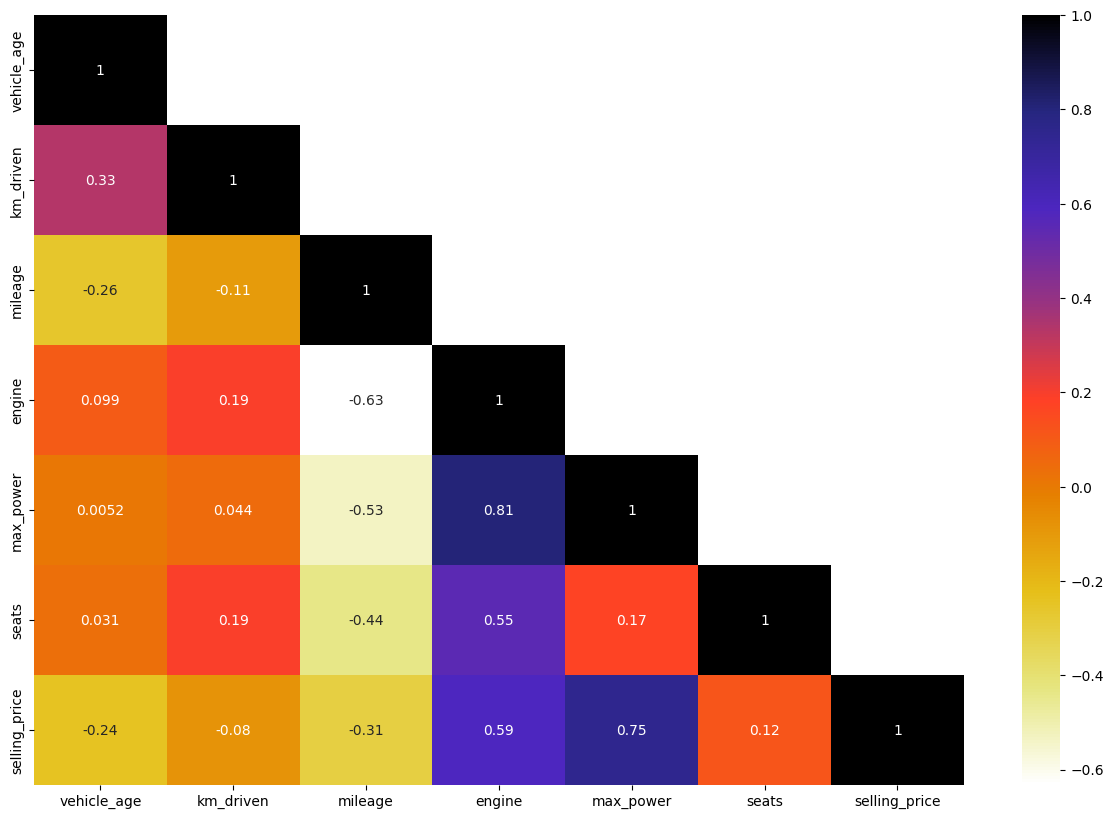

In [11]:
plt.figure(figsize = (15,10))
sns.heatmap(df[numeric_features].corr(), cmap="CMRmap_r", annot=True, mask= np.triu(df[numeric_features].corr(), k=1))
plt.show()

**Report:**

 - Max power and Engine cc are highly correlated.
 - We can check `Variance Inflation Factor` to remove any highly correlated independent features.


### Variance Inflation Factor (VIF)
 - Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
 
 - Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [12]:
import statsmodels.api as sm

for i in range(len(numeric_features)-1):
    x = df[numeric_features[i]]
    y = df['selling_price']
    model = sm.OLS(x, y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1/ (1-rsq), 2)
    print(f"VIF of {numeric_features[i]} is {vif}")


VIF of vehicle_age is 1.34
VIF of km_driven is 1.24
VIF of mileage is 1.54
VIF of engine is 2.41
VIF of max_power is 3.13
VIF of seats is 1.77


VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable 

- This Dataset have MultiCollinearity in max_power column but not so much

Max Power and Engine are correlated but we can consider these two features because they hold important information for a vechicle.

### Check Outliers and Cap them

**Why outliers?**

Data Entry error : Human error.

Measurement error: Instrument error.

Natural error: it will be Real life data.

Intentional error: People give wrong inputs


**IQR For Outlier Handling**

For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

As some columns are skewed we go with IQR method for outlier treatment

The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

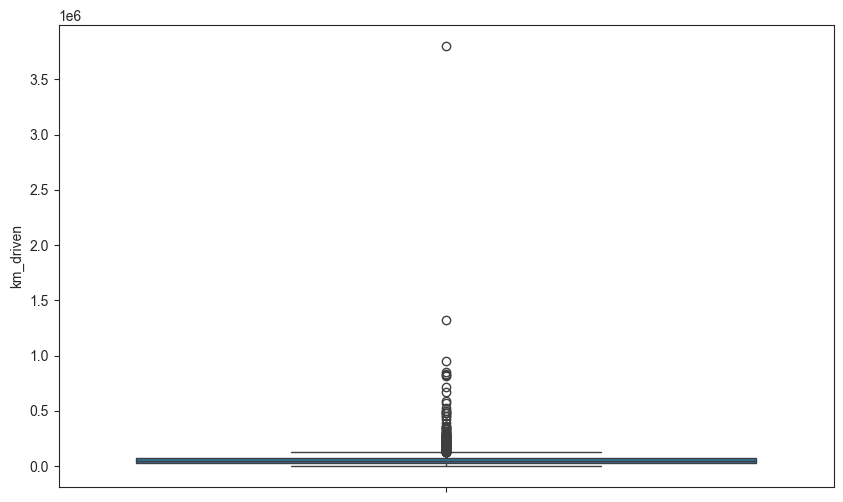

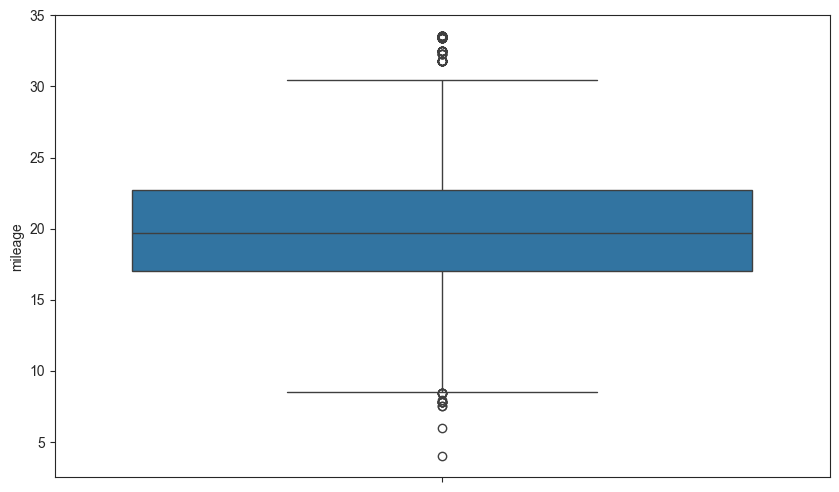

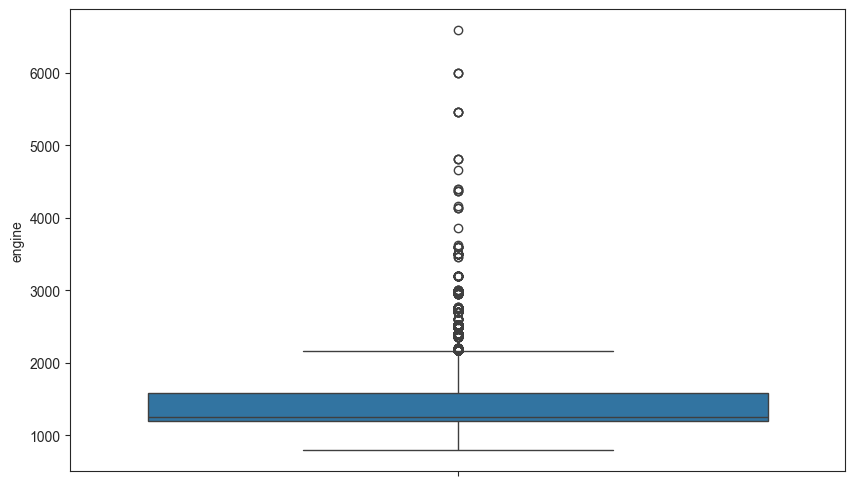

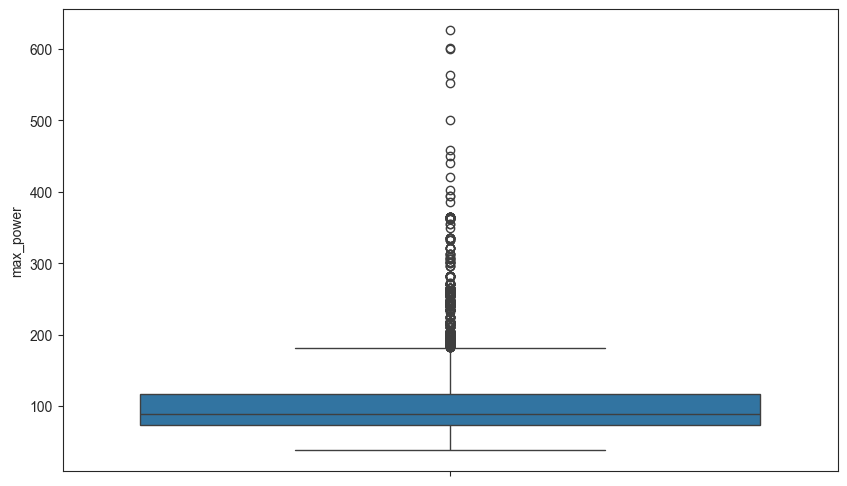

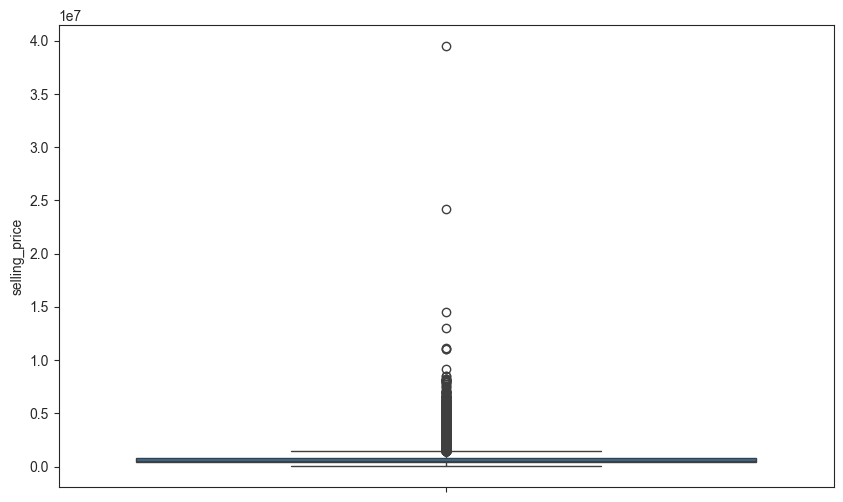

In [13]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Detecting outliers and Capping them**

In [14]:
def detect_outliers(col):
    per_25 = df[col].quantile(0.25)
    per_75 = df[col].quantile(0.75)
    print(f"\n #### {col} ####")
    print(f"25th Percentile = {per_25}")
    print(f"75th Percentile = {per_75}")
    iqr = per_75 - per_25
    upper_limit = per_75 + 1.5 * iqr
    lower_limit = per_25 - 1.5 * iqr
    print(f"Upper limit = {upper_limit}")
    print(f"Lower limit = {lower_limit}")
    df.loc[(df[col] > upper_limit), col] = upper_limit
    df.loc[(df[col] < lower_limit), col] = lower_limit
    return df

**Why are we capping it and why not trim it ?**

Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [15]:
for col in continuous_features:
         detect_outliers(col)


 #### km_driven ####
25th Percentile = 30000.0
75th Percentile = 70000.0
Upper limit = 130000.0
Lower limit = -30000.0

 #### mileage ####
25th Percentile = 17.0
75th Percentile = 22.7
Upper limit = 31.25
Lower limit = 8.450000000000001

 #### engine ####
25th Percentile = 1197.0
75th Percentile = 1582.0
Upper limit = 2159.5
Lower limit = 619.5

 #### max_power ####
25th Percentile = 74.0
75th Percentile = 117.3
Upper limit = 182.25
Lower limit = 9.050000000000011

 #### selling_price ####
25th Percentile = 385000.0
75th Percentile = 825000.0
Upper limit = 1485000.0
Lower limit = -275000.0


**Checking Skewness after Outlier Capping**

In [16]:
df[continuous_features].skew(axis=0, skipna=True)

km_driven        0.617437
mileage          0.067940
engine           0.684096
max_power        1.067229
selling_price    0.968836
dtype: float64

### Feature Transformation

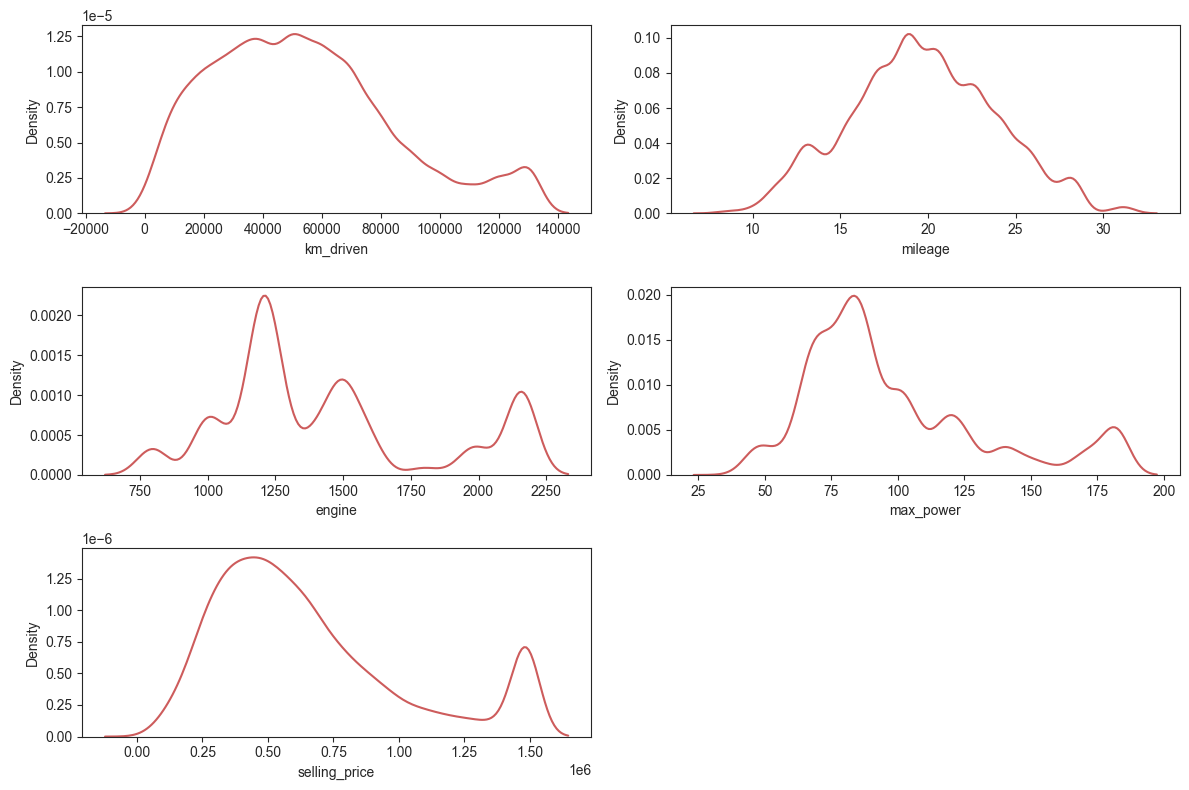

In [17]:
# distribution of data before scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(['km_driven', 'mileage', 'engine', 'max_power', 'selling_price']):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

After Capping Outlier it is all column's distribution is Normal so transformation is not required

### Splitting X and Y

In [18]:
from sklearn.model_selection import train_test_split
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

### Feature Selection

In [19]:
for feature in categoric_features:
    print(feature,':', X[feature].nunique())

car_name : 121
seller_type : 3
fuel_type : 5
transmission_type : 2


### Feature Encoding and Scaling

**One Hot Encoding** 

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Binary Encoder**

To fight the curse of dimensionality, binary encoding might be a good alternative to one-hot encoding because it creates fewer columns when encoding categorical variables.

In [20]:
num_features = X.select_dtypes(exclude="object").columns
onehot_cols = ['seller_type', 'fuel_type', 'transmission_type']
binary_cols = ['car_name']

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.binary import BinaryEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
binary_transformer = BinaryEncoder()

preprocessor = ColumnTransformer(
    [("OneHotEncoder", oh_transformer, onehot_cols),
     ("StandardScaler", numeric_transformer, num_features), 
     ("BinaryEncoder", binary_transformer, binary_cols)
    ]
)

In [21]:
X = preprocessor.fit_transform(X)

## Train Test Split

In [22]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((12328, 23), (3083, 23))

## Model Selection

- Various Regression models with default values are tried and from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### Create a Function to Evaluate Model

In [24]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    #mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    #"CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')    

Linear Regression


Model performance for Training set
- Root Mean Squared Error: 148767.4017
- Mean Absolute Error: 112822.8151
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155478.8345
- Mean Absolute Error: 118417.1508
- R2 Score: 0.8343


Lasso
Model performance for Training set
- Root Mean Squared Error: 148767.4172
- Mean Absolute Error: 112822.8031
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155479.5196
- Mean Absolute Error: 118418.6806
- R2 Score: 0.8343


Ridge
Model performance for Training set
- Root Mean Squared Error: 148770.8205
- Mean Absolute Error: 112835.0850
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155485.9482
- Mean Absolute Error: 118436.6096
- R2 Score: 0.8343


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 81915.1471
- Mean Absolute Error: 54

**Results of all models**

In [26]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=["Model Name", "R2 Score"]).sort_values(by=["R2 Score"], ascending=False)

,Model Name,R2 Score
6,XGBRegressor,0.940491
5,Random Forest Regressor,0.932498
3,K-Neighbors Regressor,0.927313
4,Decision Tree,0.896919
0,Linear Regression,0.834333
1,Lasso,0.834332
2,Ridge,0.834318
7,AdaBoost Regressor,0.793551
